<a href="https://colab.research.google.com/github/arielkeren/relationai/blob/main/RelationAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shared

In [ ]:
!pip install tensorflowjs
!pip install TensorFlow==2.15.0
!pip install tensorflow-decision-forests==1.8.1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from typing import Callable, Tuple
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflowjs.converters import save_keras_model
from tensorflow.keras.backend import clear_session

In [ ]:
# The size of the set that the relation operates on.
SET_SIZE = 5

# The size of each of the generated datasets.
TRAIN_SIZE = 600000
VALIDATION_SIZE = 200000
TEST_SIZE = 200000

# The number of epochs of every model.
EPOCHS = 10
# The batch size used during training.
BATCH_SIZE = 32

# Type representing the returned datasets from functions.
Dataset = Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]
# Type representing the returned tuple of x and y arrays from functions.
LabeledData = Tuple[np.ndarray, np.ndarray]
# Type representing a function that generates a sample for a dataset.
GenerationFunction = Callable[[], np.ndarray]

In [ ]:
clear_session()

In [ ]:
def get_property_model() -> Sequential:
  """
  Returns a model for property classification.

  Returns:
    Sequential: The compiled model.
  """

  model = Sequential()

  model.add(Input(shape=(SET_SIZE * SET_SIZE,)))
  model.add(Dense(32, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

  return model

def generate_binary_dataset(number_of_samples: int, generate_positive_case: GenerationFunction, generate_negative_case: GenerationFunction) -> LabeledData:
  """
  Generates a dataset for binary classification problems.

  Args:
    number_of_samples (int): The number of samples in the dataset.
    generate_positive_case (GenerationFunction): The function to generate the positive case.
    generate_negative_case (GenerationFunction): The function to generate the negative case.

  Returns:
    LabeledData: The generated dataset, split to x and y.
  """

  # Initialize the x and y arrays.
  x, y = [], []

  # Run for half the samples, each time adding one from each case.
  for _ in range(number_of_samples // 2):
    # Add a positive case.
    x.append(generate_positive_case())
    y.append(1)
    # Add a negative case.
    x.append(generate_negative_case())
    y.append(0)

  # Convert the arrays to Numpy arrays to manipulate them.
  x, y = np.array(x), np.array(y)

  # Randomize the arrays in the same way.
  indices = np.random.permutation(len(y))
  x, y = x[indices], y[indices]

  # Return the dataset.
  return x, y

def generate_full_binary_dataset(generate_positive_case: GenerationFunction, generate_negative_case: GenerationFunction) -> Dataset:
  """
  Generates a full dataset for binary classification problems, consisting of training, validation and test.

  Args:
    generate_positive_case (GenerationFunction): The function to generate the positive case.
    generate_negative_case (GenerationFunction): The function to generate the negative case.

  Returns:
    Dataset: The generated dataset, split to x and y.
  """

  # Generate the training dataset.
  x_train, y_train = generate_binary_dataset(TRAIN_SIZE, generate_positive_case, generate_negative_case)
  # Generate the validation dataset.
  x_val, y_val = generate_binary_dataset(VALIDATION_SIZE, generate_positive_case, generate_negative_case)
  # Generate the test dataset.
  x_test, y_test = generate_binary_dataset(TEST_SIZE, generate_positive_case, generate_negative_case)

  # Return the full dataset.
  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def generate_full_dataset(generate_case: Callable[[int], Tuple[np.ndarray, np.ndarray]]) -> Dataset:
  """
  Generates a full dataset, including training, validation and test.

  Args:
    generate_case (Callable[[], np.ndarray]): The function to generate a pair of x and y arrays.

  Returns:
    Dataset: The generated dataset.
  """

  x_train, y_train = generate_case(TRAIN_SIZE)
  x_val, y_val = generate_case(VALIDATION_SIZE)
  x_test, y_test = generate_case(TEST_SIZE)

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def get_random_relation() -> np.ndarray:
  """
  Generates a random relation.

  Returns:
    np.ndarray: The generated relation.
  """

  # 0 means that the pair satisfies the relation, and 1 means that it does not.
  return np.random.randint(0, 2, (SET_SIZE, SET_SIZE))

def plot_loss(loss: np.ndarray, val_loss: np.ndarray) -> None:
  """
  Plots the training loss and the validation loss of a model.

  Args:
    loss (np.ndarray): The training loss of the model to plot.
    val_loss (np.ndarray): The validation loss of the model to plot.
  """

  plt.plot(loss, label="Training Loss")
  plt.plot(val_loss, label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def plot_accuracy(accuracy: np.ndarray, val_accuracy: np.ndarray) -> None:
  """
  Plots the training accuracy and the validation accuracy of a model.

  Args:
    loss (np.ndarray): The training accuracy of the model to plot.
    val_loss (np.ndarray): The validation accuracy of the model to plot.
  """

  plt.plot(accuracy, label="Training Accuracy")
  plt.plot(val_accuracy, label="Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

def operation_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
  """
  Calculates the accuracy of an operation model.

  Args:
    y_true (tf.Tensor): The true values.
    y_pred (tf.Tensor): The predicted values.

  Returns:
    tf.Tensor: The accuracy of the operation model.
  """

  # Convert predictions to binary.
  y_pred_binary = tf.cast(y_pred >= 0.5, tf.bool)

  # Convert true values to boolean.
  y_true_binary = tf.cast(y_true, tf.bool)

  # Check if all the elements in each row are equal.
  correct_predictions = tf.reduce_all(tf.equal(y_pred_binary, y_true_binary), axis=1)

  # Compute the accuracy as the average of the correct predictions.
  return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# Reflexivity

In [ ]:
def generate_reflexive_matrix() -> np.ndarray:
  """
  Generates a reflexive matrix.

  Returns:
    np.ndarray: The generated reflexive matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()
  # Fill the main diagonal with ones, so that for every element x, (x, x) satisfies the relation.
  np.fill_diagonal(matrix, 1)

  return matrix.flatten()

def generate_non_reflexive_matrix() -> np.ndarray:
  """
  Generates a non-reflexive matrix.

  Returns:
    np.ndarray: The generated non-reflexive matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()
  # Ensure that it is not reflexive, by randomly making pairs on the main diagonal not satisfy the relation.
  for _ in range(np.random.randint(1, 5)):
    # Each time, pick a random pair from the main diagonal and set it to 0.
    index = np.random.randint(0, SET_SIZE)
    matrix[index][index] = 0

  return matrix.flatten()

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_binary_dataset(generate_reflexive_matrix, generate_non_reflexive_matrix)

In [ ]:
model = get_property_model()

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 37s 2ms/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 6.1800e-06 - val_accuracy: 1.0000
Epoch 2/10
18750/18750 [==============================] - 40s 2ms/step - loss: 5.8795e-07 - accuracy: 1.0000 - val_loss: 1.0011e-08 - val_accuracy: 1.0000
Epoch 3/10
18750/18750 [==============================] - 41s 2ms/step - loss: 8.8980e-09 - accuracy: 1.0000 - val_loss: 8.3693e-09 - val_accuracy: 1.0000
Epoch 4/10
18750/18750 [==============================] - 43s 2ms/step - loss: 8.2747e-09 - accuracy: 1.0000 - val_loss: 8.0656e-09 - val_accuracy: 1.0000
Epoch 5/10
18750/18750 [==============================] - 41s 2ms/step - loss: 8.1471e-09 - accuracy: 1.0000 - val_loss: 7.9180e-09 - val_accuracy: 1.0000
Epoch 6/10
18750/18750 [==============================] - 37s 2ms/step - loss: 8.0903e-09 - accuracy: 1.0000 - val_loss: 8.0158e-09 - val_accuracy: 1.0000
Epoch 7/10
18750/18750 [==============================] - 37s 2ms/step - l

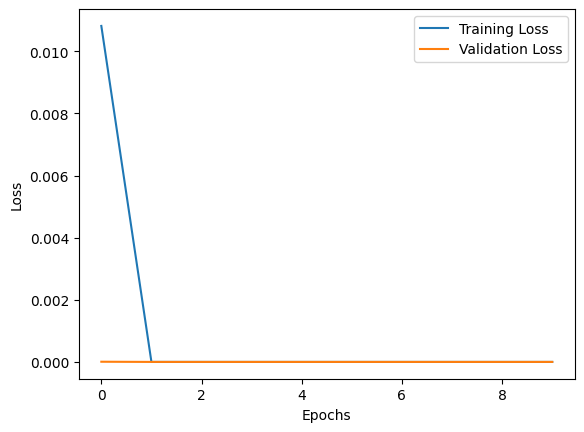

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

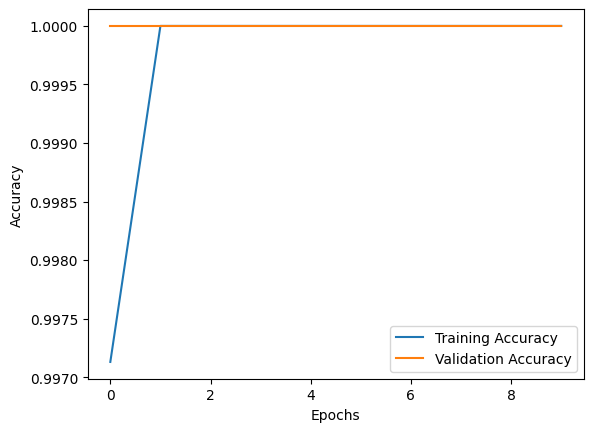

In [ ]:
plot_accuracy(history.history["accuracy"], history.history["val_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 10s 2ms/step - loss: 8.1076e-09 - accuracy: 1.0000


[8.107606142004897e-09, 1.0]

In [ ]:
save_keras_model(model, '/content/reflexivity')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Irreflexivity

In [ ]:
def generate_irreflexive_matrix() -> np.ndarray:
  """
  Generates an irreflexive matrix.

  Returns:
    np.ndarray: The generated irreflexive matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()
  # Fill the main diagonal with zeros, so that for every element x, (x, x) does not satisfy the relation.
  np.fill_diagonal(matrix, 0)

  return matrix.flatten()

def generate_non_irreflexive_matrix() -> np.ndarray:
  """
  Generates a non-irreflexive matrix.

  Returns:
    np.ndarray: The generated non-irreflexive matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()
  # Ensure that it is not irreflexive, by randomly making pairs on the main diagonal satisfy the relation.
  for _ in range(np.random.randint(1, 5)):
    # Each time, pick a random pair from the main diagonal and set it to 1.
    i = np.random.randint(0, SET_SIZE)
    matrix[i][i] = 1

  return matrix.flatten()

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_binary_dataset(generate_irreflexive_matrix, generate_non_irreflexive_matrix)

In [ ]:
model = get_property_model()

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 43s 2ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 1.1177e-07 - val_accuracy: 1.0000
Epoch 2/10
18750/18750 [==============================] - 40s 2ms/step - loss: 2.0783e-08 - accuracy: 1.0000 - val_loss: 1.0393e-08 - val_accuracy: 1.0000
Epoch 3/10
18750/18750 [==============================] - 41s 2ms/step - loss: 9.6502e-09 - accuracy: 1.0000 - val_loss: 8.9564e-09 - val_accuracy: 1.0000
Epoch 4/10
18750/18750 [==============================] - 42s 2ms/step - loss: 8.6138e-09 - accuracy: 1.0000 - val_loss: 8.4118e-09 - val_accuracy: 1.0000
Epoch 5/10
18750/18750 [==============================] - 40s 2ms/step - loss: 8.1271e-09 - accuracy: 1.0000 - val_loss: 7.9755e-09 - val_accuracy: 1.0000
Epoch 6/10
18750/18750 [==============================] - 40s 2ms/step - loss: 7.7589e-09 - accuracy: 1.0000 - val_loss: 7.7154e-09 - val_accuracy: 1.0000
Epoch 7/10
18750/18750 [==============================] - 40s 2ms/step - l

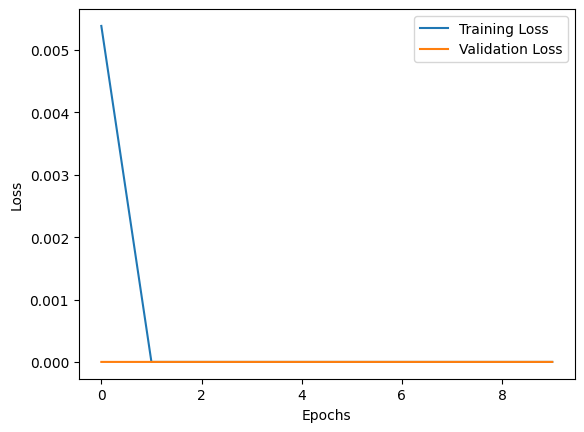

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

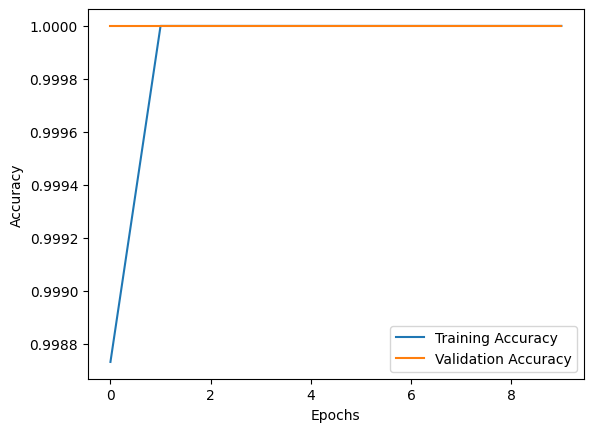

In [ ]:
plot_accuracy(history.history["accuracy"], history.history["val_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 8s 1ms/step - loss: 6.8536e-09 - accuracy: 1.0000


[6.853591916211599e-09, 1.0]

In [ ]:
save_keras_model(model, '/content/irreflexivity')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Symmetry

In [ ]:
def generate_symmetric_matrix() -> np.ndarray:
  """
  Generates a symmetric matrix.

  Returns:
    np.ndarray: The generated symmetric matrix.
  """

  # Create a random matrix.
  random_matrix = get_random_relation()
  # Copy only the values on the main diagonal or above to a new matrix.
  matrix = np.triu(random_matrix, 0)
  # Mirror the upper values to ensure that the matrix is symmetric.
  matrix += np.triu(random_matrix, 1).T

  return matrix.flatten()

def generate_non_symmetric_matrix() -> np.ndarray:
  """
  Generates a non-symmetric matrix.

  Returns:
    np.ndarray: The generated non-symmetric matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Ensure a non-symmetric matrix, by making some asymmetric pairs satisfy the relation.
  for _ in range(np.random.randint(1, 5)):
    # Choose 2 random pairs
    i, j = np.random.randint(0, SET_SIZE, 2)
    # Make them asymmetric
    if i != j:
      matrix[i][j] = 1 - matrix[j][i]

  return matrix.flatten()

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_binary_dataset(generate_symmetric_matrix, generate_non_symmetric_matrix)

In [ ]:
model = get_property_model()

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 42s 2ms/step - loss: 0.0300 - accuracy: 0.9923 - val_loss: 3.2451e-04 - val_accuracy: 1.0000
Epoch 2/10
18750/18750 [==============================] - 40s 2ms/step - loss: 4.0372e-04 - accuracy: 1.0000 - val_loss: 1.9856e-04 - val_accuracy: 1.0000
Epoch 3/10
18750/18750 [==============================] - 38s 2ms/step - loss: 3.8484e-04 - accuracy: 1.0000 - val_loss: 2.1163e-04 - val_accuracy: 1.0000
Epoch 4/10
18750/18750 [==============================] - 41s 2ms/step - loss: 3.4128e-04 - accuracy: 1.0000 - val_loss: 1.8605e-04 - val_accuracy: 1.0000
Epoch 5/10
18750/18750 [==============================] - 40s 2ms/step - loss: 3.5763e-04 - accuracy: 1.0000 - val_loss: 2.0473e-04 - val_accuracy: 1.0000
Epoch 6/10
18750/18750 [==============================] - 38s 2ms/step - loss: 3.4712e-04 - accuracy: 1.0000 - val_loss: 2.3128e-04 - val_accuracy: 1.0000
Epoch 7/10
18750/18750 [==============================] - 39s 2ms/step - l

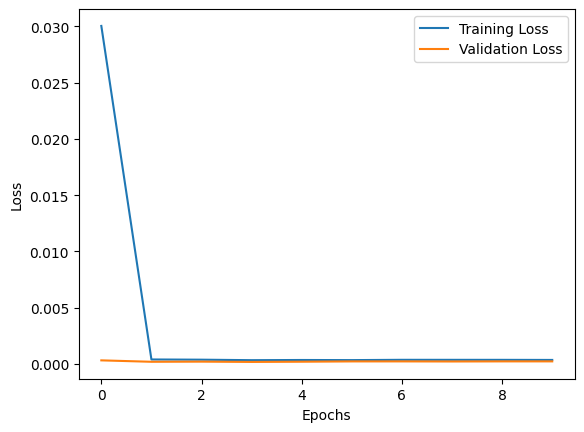

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

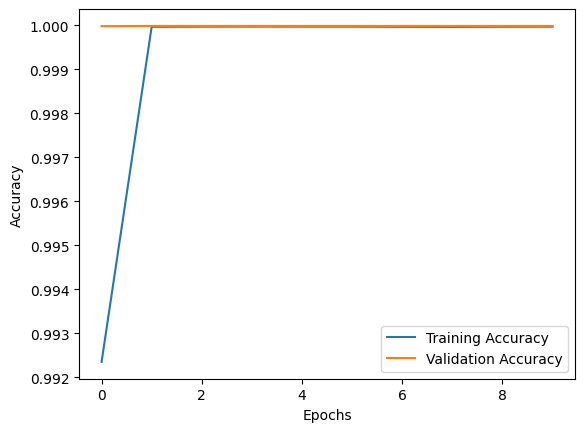

In [ ]:
plot_accuracy(history.history["accuracy"], history.history["val_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 8s 1ms/step - loss: 6.1770e-04 - accuracy: 1.0000


[0.0006177007453516126, 0.9999600052833557]

In [ ]:
save_keras_model(model, '/content/symmetry')

# Asymmetry

In [ ]:
def generate_asymmetric_matrix() -> np.ndarray:
  """
  Generates an asymmetric matrix.

  Returns:
    np.ndarray: The generated asymmetric matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Make all pairs asymmetric
  for i in range(SET_SIZE):
    for j in range(SET_SIZE):
      if matrix[i][j]:
        matrix[j][i] = 0

  return matrix.flatten()

def generate_non_asymmetric_matrix() -> np.ndarray:
  """
  Generates a non-asymmetric matrix.

  Returns:
    np.ndarray: The generated non-asymmetric matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Ensure that the relation is not asymmetric, by making symmetric pairs.
  for _ in range(np.random.randint(1, 5)):
    # Choose 2 pairs randomly.
    i, j = np.random.randint(0, SET_SIZE, 2)
    # Make them symmetric.
    matrix[i][j] = 1
    matrix[j][i] = 1

  return matrix.flatten()

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_binary_dataset(generate_asymmetric_matrix, generate_non_asymmetric_matrix)

In [ ]:
model = get_property_model()

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 41s 2ms/step - loss: 0.0170 - accuracy: 0.9955 - val_loss: 0.0044 - val_accuracy: 0.9989
Epoch 2/10
18750/18750 [==============================] - 38s 2ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0031 - val_accuracy: 0.9998
Epoch 3/10
18750/18750 [==============================] - 40s 2ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 9.7297e-04 - val_accuracy: 0.9998
Epoch 4/10
18750/18750 [==============================] - 40s 2ms/step - loss: 8.8324e-04 - accuracy: 0.9998 - val_loss: 5.8936e-04 - val_accuracy: 0.9999
Epoch 5/10
18750/18750 [==============================] - 38s 2ms/step - loss: 6.3742e-04 - accuracy: 0.9998 - val_loss: 4.9290e-04 - val_accuracy: 0.9998
Epoch 6/10
18750/18750 [==============================] - 39s 2ms/step - loss: 5.0723e-04 - accuracy: 0.9999 - val_loss: 3.6451e-04 - val_accuracy: 0.9999
Epoch 7/10
18750/18750 [==============================] - 37s 2ms/step - loss: 3.9190e-04 

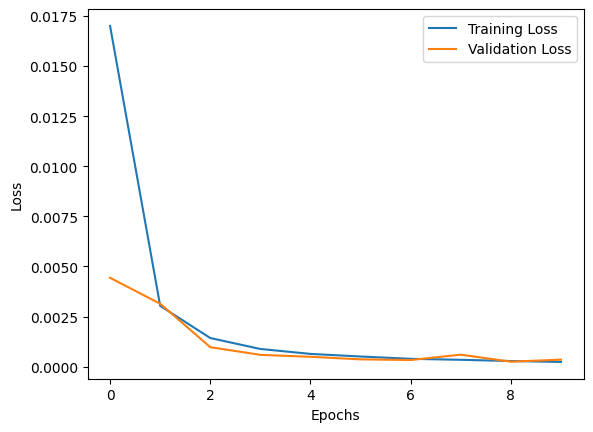

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

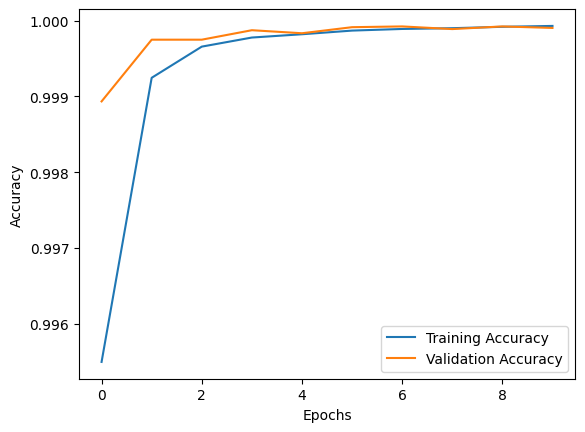

In [ ]:
plot_accuracy(history.history["accuracy"], history.history["val_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 9s 1ms/step - loss: 3.6642e-04 - accuracy: 0.9999


[0.0003664199321065098, 0.9998999834060669]

In [ ]:
save_keras_model(model, '/content/asymmetry')

# Antisymmetry

In [ ]:
def generate_antisymmetric_matrix() -> np.ndarray:
  """
  Generates an antisymmetric matrix.

  Returns:
    np.ndarray: The generated antisymmetric matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Ensure that the relation is antisymmetric.
  for i in range(SET_SIZE):
    for j in range(SET_SIZE):
      # Skip the main diagonal.
      if i == j:
        continue

      # Ensure antisymmetry.
      if matrix[i][j]:
        matrix[j][i] = 0

  return matrix.flatten()

def generate_non_antisymmetric_matrix() -> np.ndarray:
  """
  Generates a non-antisymmetric matrix.

  Returns:
    np.ndarray: The generated non-antisymmetric matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Ensure that the relation is not antisymmetric, by making some symmetric pairs.
  for _ in range(np.random.randint(1, 5)):
    # Initialize some indices.
    i, j = 0, 0

    # Skip the main diagonal.
    while i == j:
      i, j = np.random.randint(0, SET_SIZE, 2)

    # Make the pairs symmetric.
    matrix[i][j] = 1
    matrix[j][i] = 1

  return matrix.flatten()

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_binary_dataset(generate_antisymmetric_matrix, generate_non_antisymmetric_matrix)

In [ ]:
model = get_property_model()

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 39s 2ms/step - loss: 0.0500 - accuracy: 0.9840 - val_loss: 0.0091 - val_accuracy: 0.9970
Epoch 2/10
18750/18750 [==============================] - 40s 2ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0013 - val_accuracy: 0.9999
Epoch 3/10
18750/18750 [==============================] - 40s 2ms/step - loss: 5.1016e-04 - accuracy: 1.0000 - val_loss: 1.3465e-04 - val_accuracy: 1.0000
Epoch 4/10
18750/18750 [==============================] - 40s 2ms/step - loss: 7.1176e-05 - accuracy: 1.0000 - val_loss: 2.0840e-05 - val_accuracy: 1.0000
Epoch 5/10
18750/18750 [==============================] - 43s 2ms/step - loss: 1.0604e-05 - accuracy: 1.0000 - val_loss: 4.9312e-06 - val_accuracy: 1.0000
Epoch 6/10
18750/18750 [==============================] - 40s 2ms/step - loss: 2.8962e-06 - accuracy: 1.0000 - val_loss: 1.2505e-06 - val_accuracy: 1.0000
Epoch 7/10
18750/18750 [==============================] - 39s 2ms/step - loss: 4.9007e

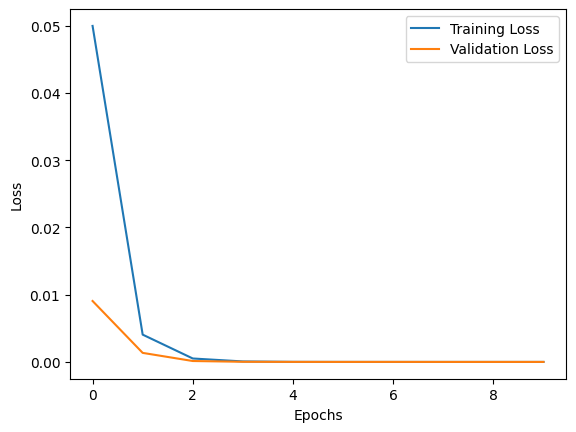

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

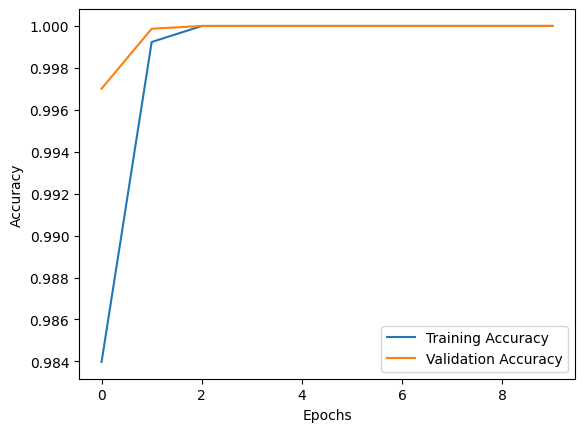

In [ ]:
plot_accuracy(history.history["accuracy"], history.history["val_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 9s 1ms/step - loss: 5.1431e-09 - accuracy: 1.0000


[5.143057979495325e-09, 1.0]

In [ ]:
save_keras_model(model, '/content/antisymmetry')

# Transitivity

In [ ]:
def generate_transitive_matrix() -> np.ndarray:
  """
  Generates a transitive matrix.

  Returns:
    np.ndarray: The generated transitive matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Ensure transitivity.
  for k in range(SET_SIZE):
    for i in range(SET_SIZE):
      for j in range(SET_SIZE):
        if matrix[i][k] and matrix[k][j]:
          matrix[i][j] = 1

  return matrix.flatten()

def generate_non_transitive_matrix() -> np.ndarray:
  """
  Generates a non-transitive matrix.

  Returns:
    np.ndarray: The generated non-transitive matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Violate transitivity.
  for _ in range(np.random.randint(1, 5)):
    # Choose 3 random indices.
    i, j, k = np.random.randint(0, SET_SIZE, 3)

    # Make them violate transitivity.
    matrix[i][j] = 1
    matrix[j][k] = 1
    matrix[i][k] = 0

  return matrix.flatten()

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_binary_dataset(generate_transitive_matrix, generate_non_transitive_matrix)

In [ ]:
model = get_property_model()

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 42s 2ms/step - loss: 0.0596 - accuracy: 0.9813 - val_loss: 0.0214 - val_accuracy: 0.9938
Epoch 2/10
18750/18750 [==============================] - 40s 2ms/step - loss: 0.0184 - accuracy: 0.9945 - val_loss: 0.0172 - val_accuracy: 0.9946
Epoch 3/10
18750/18750 [==============================] - 40s 2ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.0157 - val_accuracy: 0.9950
Epoch 4/10
18750/18750 [==============================] - 41s 2ms/step - loss: 0.0137 - accuracy: 0.9958 - val_loss: 0.0140 - val_accuracy: 0.9954
Epoch 5/10
18750/18750 [==============================] - 41s 2ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.0123 - val_accuracy: 0.9961
Epoch 6/10
18750/18750 [==============================] - 39s 2ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.0118 - val_accuracy: 0.9962
Epoch 7/10
18750/18750 [==============================] - 41s 2ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0

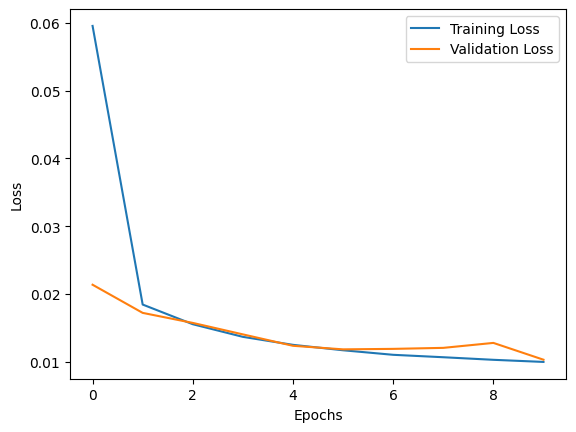

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

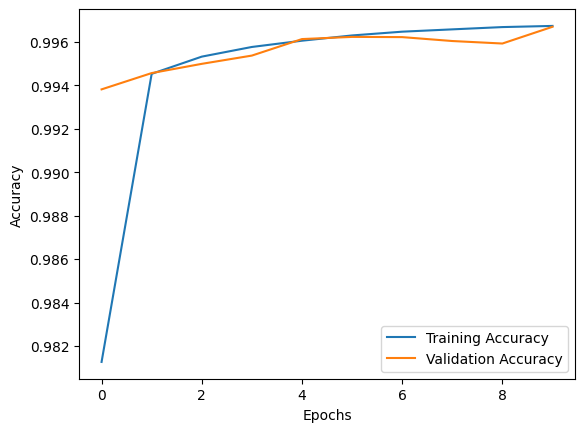

In [ ]:
plot_accuracy(history.history["accuracy"], history.history["val_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 10s 2ms/step - loss: 0.0103 - accuracy: 0.9968


[0.010250959545373917, 0.9968249797821045]

In [ ]:
save_keras_model(model, '/content/transitivity')

# Antitransitivity

In [ ]:
def generate_antitransitive_matrix() -> np.ndarray:
  """
  Generates an antitransitive matrix.

  Returns:
    np.ndarray: The generated antitransitive matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Ensure antitransitivity.
  for k in range(SET_SIZE):
    for i in range(SET_SIZE):
      for j in range(SET_SIZE):
        if matrix[i][k] and matrix[k][j]:
          matrix[i][j] = 0

  return matrix.flatten()

def generate_non_antitransitive_matrix() -> np.ndarray:
  """
  Generates a non-antitransitive matrix.

  Returns:
    np.ndarray: The generated non-antitransitive matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Violate antitransitivity.
  for _ in range(np.random.randint(1, 5)):
    # Choose 3 random indices.
    i, j, k = np.random.randint(0, SET_SIZE, 3)

    # Make them violate antitransitivity.
    matrix[i][j] = 1
    matrix[j][k] = 1
    matrix[i][k] = 1

  return matrix.flatten()

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_binary_dataset(generate_antitransitive_matrix, generate_non_antitransitive_matrix)

In [ ]:
model = get_property_model()

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 41s 2ms/step - loss: 0.0109 - accuracy: 0.9971 - val_loss: 0.0037 - val_accuracy: 0.9992
Epoch 2/10
18750/18750 [==============================] - 42s 2ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 3/10
18750/18750 [==============================] - 39s 2ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 4/10
18750/18750 [==============================] - 40s 2ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 5/10
18750/18750 [==============================] - 40s 2ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 6/10
18750/18750 [==============================] - 42s 2ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 7/10
18750/18750 [==============================] - 38s 2ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0

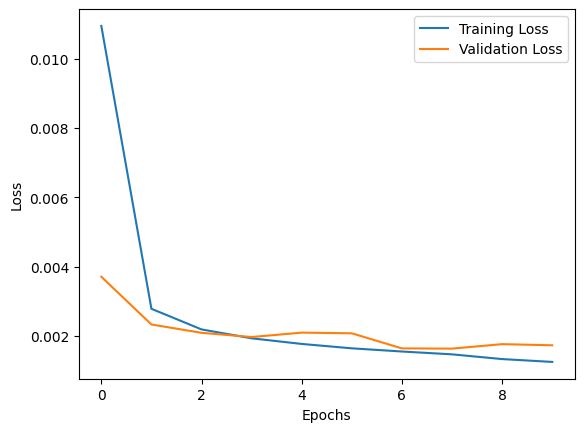

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

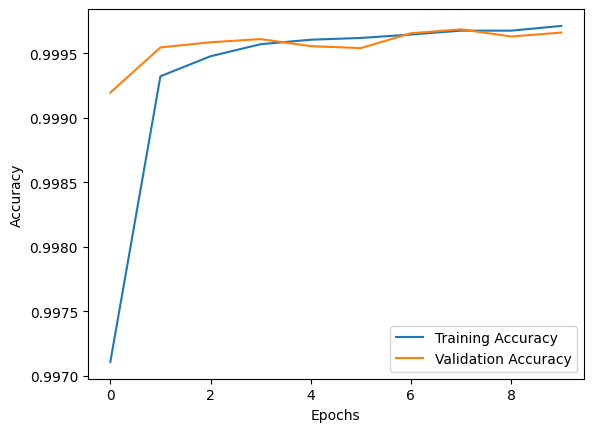

In [ ]:
plot_accuracy(history.history["accuracy"], history.history["val_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 9s 1ms/step - loss: 0.0014 - accuracy: 0.9997


[0.0013947990955784917, 0.9997100234031677]

In [ ]:
save_keras_model(model, '/content/antitransitivity')

# Totality

In [ ]:
def generate_totality_matrix() -> np.ndarray:
  """
  Generates a totality matrix.

  Returns:
    np.ndarray: The generated totality matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Ensure totality.
  for i in range(SET_SIZE):
    for j in range(SET_SIZE):
      # This pair already satisfies totality.
      if matrix[i][j] or matrix[j][i]:
        continue

      # Choose randomly which pair gets to satisfy the relation.
      if np.random.randint(0, 2) == 0:
        matrix[i][j] = 1
      else:
        matrix[j][i] = 1

  return matrix.flatten()

def generate_non_totality_matrix() -> np.ndarray:
  """
  Generates a non-totality matrix.

  Returns:
    np.ndarray: The generated non-totality matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Violate totality.
  for _ in range(np.random.randint(1, 5)):
    # Choose 2 indices by random.
    i, j = np.random.randint(0, SET_SIZE, 2)

    # Make them violate totality.
    matrix[i][j] = 0
    matrix[j][i] = 0

  return matrix.flatten()

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_binary_dataset(generate_totality_matrix, generate_non_totality_matrix)

In [ ]:
model = get_property_model()

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 41s 2ms/step - loss: 0.0205 - accuracy: 0.9942 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 2/10
18750/18750 [==============================] - 40s 2ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0014 - val_accuracy: 0.9998
Epoch 3/10
18750/18750 [==============================] - 38s 2ms/step - loss: 9.5619e-04 - accuracy: 0.9997 - val_loss: 7.3742e-04 - val_accuracy: 0.9997
Epoch 4/10
18750/18750 [==============================] - 41s 2ms/step - loss: 6.5151e-04 - accuracy: 0.9998 - val_loss: 6.8794e-04 - val_accuracy: 0.9998
Epoch 5/10
18750/18750 [==============================] - 41s 2ms/step - loss: 4.7834e-04 - accuracy: 0.9999 - val_loss: 3.0854e-04 - val_accuracy: 0.9999
Epoch 6/10
18750/18750 [==============================] - 38s 2ms/step - loss: 3.5127e-04 - accuracy: 0.9999 - val_loss: 2.6092e-04 - val_accuracy: 0.9999
Epoch 7/10
18750/18750 [==============================] - 40s 2ms/step - loss: 2.3336e

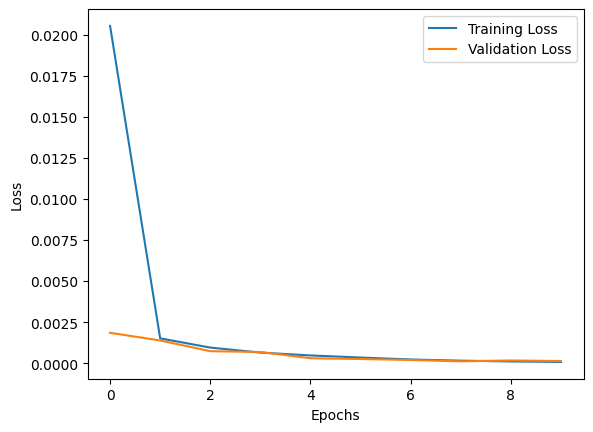

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

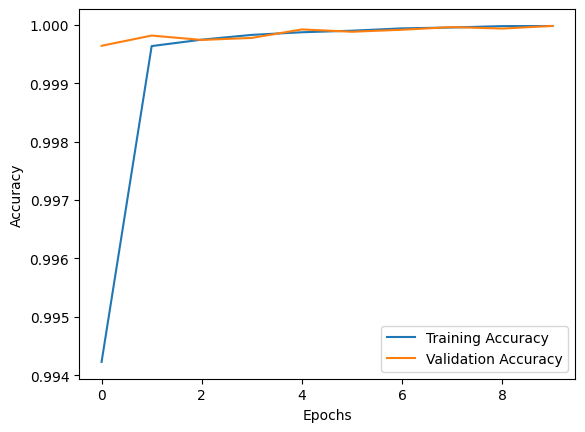

In [ ]:
plot_accuracy(history.history["accuracy"], history.history["val_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 9s 1ms/step - loss: 2.2773e-04 - accuracy: 0.9999


[0.00022772788361180574, 0.9999449849128723]

In [ ]:
save_keras_model(model, '/content/totality')

# Trichotomy

In [ ]:
def generate_trichotomy_matrix() -> np.ndarray:
  """
  Generates a trichotomy matrix.

  Returns:
    np.ndarray: The generated trichotomy matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Ensure trichotomy.
  for i in range(SET_SIZE):
    for j in range(SET_SIZE):
      # Skip the main diagonal or when the pair already satisfies trichotomy.
      if i == j or matrix[i][j] or matrix[j][i]:
        continue

      # Choose one of the 2 pairs by random to satisfy the relation.
      if np.random.randint(0, 2) == 0:
        matrix[i][j] = 1
      else:
        matrix[j][i] = 1

  return matrix.flatten()

def generate_non_trichotomy_matrix() -> np.ndarray:
  """
  Generates a non-trichotomy matrix.

  Returns:
    np.ndarray: The generated non-trichotomy matrix.
  """

  # Create a random matrix.
  matrix = get_random_relation()

  # Violate trichotomy.
  for _ in range(np.random.randint(1, 5)):
    # Initialize 2 indices.
    i, j = 0, 0

    # Skip the main diagonal.
    while i == j:
      i, j = np.random.randint(0, SET_SIZE, 2)

    # Make the pairs violate trichotomy.
    matrix[i][j] = 0
    matrix[j][i] = 0

  return matrix.flatten()

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_binary_dataset(generate_trichotomy_matrix, generate_non_trichotomy_matrix)

In [ ]:
model = get_property_model()

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 39s 2ms/step - loss: 0.0585 - accuracy: 0.9813 - val_loss: 0.0065 - val_accuracy: 0.9994
Epoch 2/10
18750/18750 [==============================] - 41s 2ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0014 - val_accuracy: 0.9998
Epoch 3/10
18750/18750 [==============================] - 40s 2ms/step - loss: 9.0873e-04 - accuracy: 0.9999 - val_loss: 4.1666e-04 - val_accuracy: 0.9999
Epoch 4/10
18750/18750 [==============================] - 41s 2ms/step - loss: 3.0295e-04 - accuracy: 1.0000 - val_loss: 2.5525e-04 - val_accuracy: 1.0000
Epoch 5/10
18750/18750 [==============================] - 41s 2ms/step - loss: 1.1332e-04 - accuracy: 1.0000 - val_loss: 5.8973e-05 - val_accuracy: 1.0000
Epoch 6/10
18750/18750 [==============================] - 38s 2ms/step - loss: 4.1220e-05 - accuracy: 1.0000 - val_loss: 1.3366e-05 - val_accuracy: 1.0000
Epoch 7/10
18750/18750 [==============================] - 40s 2ms/step - loss: 1.2843e

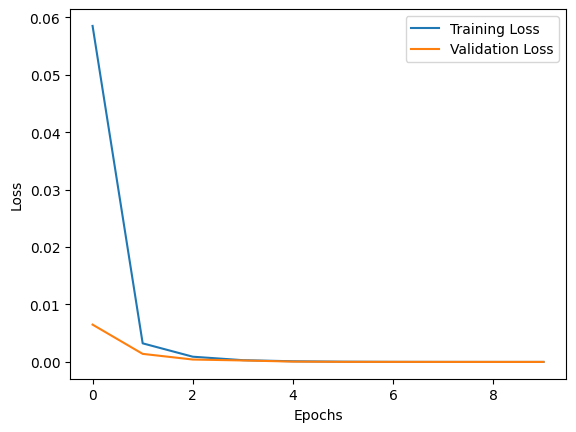

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

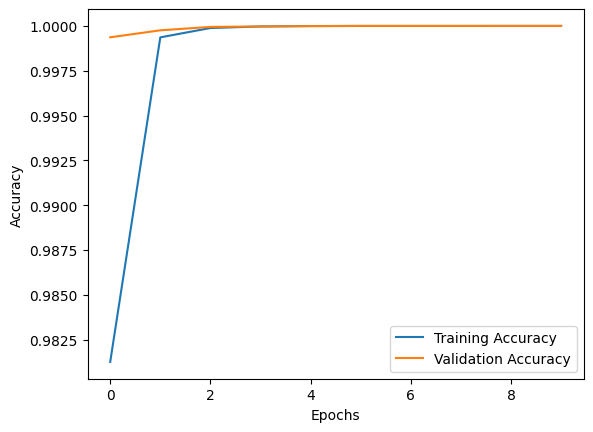

In [ ]:
plot_accuracy(history.history["accuracy"], history.history["val_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 9s 1ms/step - loss: 2.8283e-08 - accuracy: 1.0000


[2.828317846592654e-08, 1.0]

In [ ]:
save_keras_model(model, '/content/trichotomy')

# Inversion

In [ ]:
def generate_inversion_dataset(number_of_samples: int) -> LabeledData:
  """
  Generates an inversion dataset.

  Args:
    number_of_samples (int): The number of samples to generate.

  Returns:
    LabeledData: The generated inversion dataset.
  """

  # Generate an array of random matrices.
  x = np.random.randint(0, 2, (number_of_samples, SET_SIZE, SET_SIZE))
  # Transpose the array to get the inverse of each matrix.
  y = x.transpose(0, 2, 1)

  # Flatten the matrices.
  x = x.reshape((number_of_samples, SET_SIZE * SET_SIZE))
  y = y.reshape((number_of_samples, SET_SIZE * SET_SIZE))

  return x, y

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_dataset(generate_inversion_dataset)

In [ ]:
model = Sequential()

model.add(Input(shape=(SET_SIZE * SET_SIZE,)))
model.add(Dense(32, activation="relu"))
model.add(Dense(SET_SIZE * SET_SIZE, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[operation_accuracy])

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 46s 2ms/step - loss: 0.0188 - operation_accuracy: 0.9715 - val_loss: 4.7145e-07 - val_operation_accuracy: 1.0000
Epoch 2/10
18750/18750 [==============================] - 42s 2ms/step - loss: 7.9380e-08 - operation_accuracy: 1.0000 - val_loss: 2.0820e-08 - val_operation_accuracy: 1.0000
Epoch 3/10
18750/18750 [==============================] - 45s 2ms/step - loss: 1.5276e-08 - operation_accuracy: 1.0000 - val_loss: 1.2392e-08 - val_operation_accuracy: 1.0000
Epoch 4/10
18750/18750 [==============================] - 45s 2ms/step - loss: 1.0525e-08 - operation_accuracy: 1.0000 - val_loss: 9.3972e-09 - val_operation_accuracy: 1.0000
Epoch 5/10
18750/18750 [==============================] - 42s 2ms/step - loss: 8.4705e-09 - operation_accuracy: 1.0000 - val_loss: 7.9576e-09 - val_operation_accuracy: 1.0000
Epoch 6/10
18750/18750 [==============================] - 42s 2ms/step - loss: 7.2819e-09 - operation_accuracy: 1.0000 - val_loss

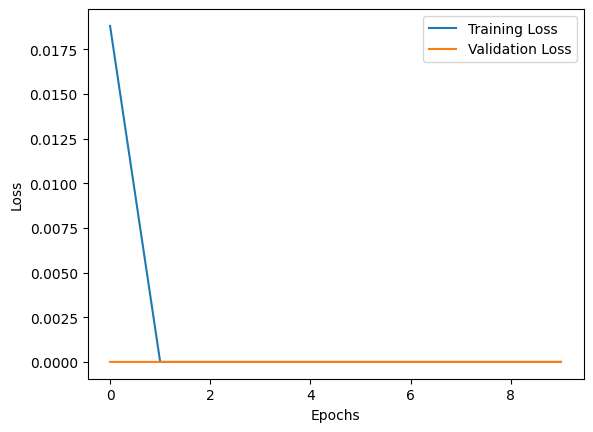

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

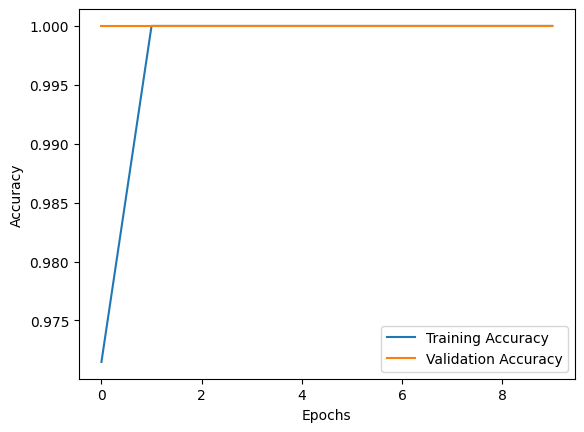

In [ ]:
plot_accuracy(history.history["operation_accuracy"], history.history["val_operation_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 10s 2ms/step - loss: 4.9114e-09 - operation_accuracy: 1.0000


[4.911436590759877e-09, 1.0]

In [ ]:
save_keras_model(model, '/content/inversion')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Composition

In [ ]:
def compose_relation(relation: np.ndarray) -> np.ndarray:
  """
  Composes a relation with itself.

  Args:
    relation (np.ndarray): The relation to compose.

  Returns:
    np.ndarray: The composed relation.
  """

  # Initialize the composed relation.
  composed = np.zeros((SET_SIZE, SET_SIZE))

  # Build the composed relation from the original.
  for i in range(SET_SIZE):
    for j in range(SET_SIZE):
      for k in range(SET_SIZE):
        composed[i][k] = composed[i][k] or (relation[i][j] and relation[j][k])

  return composed

def generate_composition_dataset(number_of_samples: int) -> LabeledData:
  """
  Generates a composition dataset.

  Args:
    number_of_samples (int): The number of samples to generate.

  Returns:
    LabeledData: The generated composition dataset.
  """

  # Create an array of random relations.
  x = np.random.randint(0, 2, (number_of_samples, SET_SIZE, SET_SIZE))

  # Compose each relation with itself and store the new relations in a new array.
  y = np.array([compose_relation(relation) for relation in x])

  # Reshape the x array to fit the model.
  x = x.reshape(number_of_samples, SET_SIZE * SET_SIZE)

  # Reshape the y array to fit the model.
  y = y.reshape(number_of_samples, SET_SIZE * SET_SIZE)

  return x, y

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = generate_full_dataset(generate_composition_dataset)

In [ ]:
model = Sequential()

model.add(Input(shape=(SET_SIZE * SET_SIZE,)))
model.add(Dense(128, activation="relu"))
model.add(Dense(SET_SIZE * SET_SIZE, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[operation_accuracy])

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
18750/18750 [==============================] - 47s 2ms/step - loss: 0.1558 - operation_accuracy: 0.3464 - val_loss: 0.0532 - val_operation_accuracy: 0.6750
Epoch 2/10
18750/18750 [==============================] - 47s 2ms/step - loss: 0.0306 - operation_accuracy: 0.8044 - val_loss: 0.0182 - val_operation_accuracy: 0.8785
Epoch 3/10
18750/18750 [==============================] - 46s 2ms/step - loss: 0.0129 - operation_accuracy: 0.9143 - val_loss: 0.0092 - val_operation_accuracy: 0.9396
Epoch 4/10
18750/18750 [==============================] - 44s 2ms/step - loss: 0.0071 - operation_accuracy: 0.9542 - val_loss: 0.0054 - val_operation_accuracy: 0.9653
Epoch 5/10
18750/18750 [==============================] - 46s 2ms/step - loss: 0.0042 - operation_accuracy: 0.9738 - val_loss: 0.0033 - val_operation_accuracy: 0.9806
Epoch 6/10
18750/18750 [==============================] - 43s 2ms/step - loss: 0.0026 - operation_accuracy: 0.9850 - val_loss: 0.0020 - val_operation_accuracy: 0.989

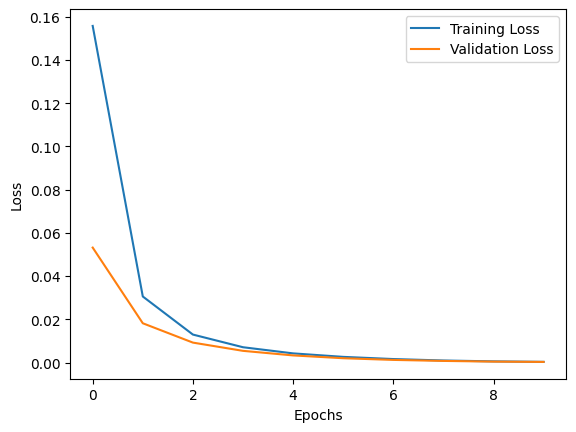

In [ ]:
plot_loss(history.history["loss"], history.history["val_loss"])

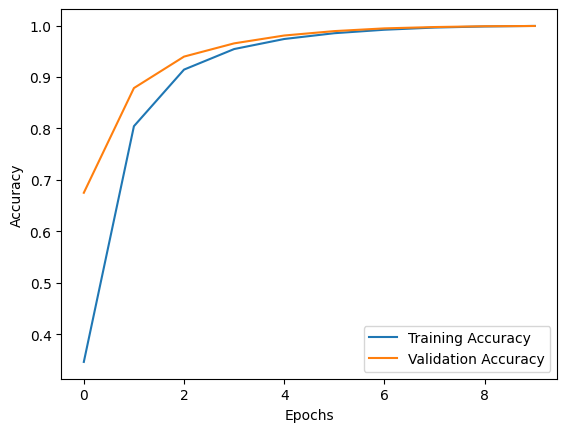

In [ ]:
plot_accuracy(history.history["operation_accuracy"], history.history["val_operation_accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

6250/6250 [==============================] - 10s 2ms/step - loss: 2.8289e-04 - operation_accuracy: 0.9990


[0.00028289100737310946, 0.998960018157959]

In [ ]:
save_keras_model(model, '/content/composition')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
